## Optimal Taxation Simulation - Constant Elasticity

The code below follows Mankiw, Weinzierl, and Yagan's fixed point iteration algorithm for finding the optimal tax schedule (https://eml.berkeley.edu/~yagan/MWY_appx.pdf). That said, there are quite a few implementation differences to speed things up.

**The MWY algorithm is as follows:**

1. Discretize an ability distribution in to a series of bins.
    * For each bin, we will evaluate at the mean; in other words, if we look at the original distribution at resolution $\Delta$, then for some bin [$w - \Delta/2$, $w + \Delta/2$], we assume everyone has ability $w$. We will solve the optimization problem at a list of such $w's$, call this vector $W$.
2. Specify some tax schedule of the form $T'(w)$, and government transfer, t.
    * In this economy, any government revenue raised is returned in the form of lump-sum transfers.
3. For each $w \in W$, solve for the household's best response $(l(w), c(w), z(w))$
    * We know marginal rates as a function of ability, but not $z$.
    * As a result, we will solve in increasing orders of ability.
    * By the time we get to $w_i := W[i]$, we will apply $T'(w_0)$ on $[0, z(w_0))$, ... , $T'(w_{i-1})$ on $[z(w_{i-2}), z(w_{i-1}))$, and $T'(w_i)$ on any income above that.
4. Solve for $T'(z)$ using a discretized version of the social planner's FOC for $\{z(w) | w \in W\}$.
5. Using the new schedule from (4), repeat step 3 with the old government transfer.
    * This tells us how much revenue would be collected, and in turn, the new government transfer.
6. Repeat steps (3) through (5) using the new schedule and the new transfer until the update for both is below some tolerance thereshold. 

---

**Differences:**

Several implementation differences are discussed in the releavnt code blocks. In terms of the algorithm, 

* (**DOES NOT APPLY IN THIS VERSION**) For the third bullet point of (3), MWY uses $T'(w_i)$ for incomes above $z(w_{i-1})$.
* In step 5, MWY averages the rate from the schedule used that turn and the new schedule from (4). The benefit of these distinctions are not clear to me.
* I do not check the second order conditon.
* 01/27: Condensed steps 3 and 4.
* 01/29: Loaded their 2007 distribution directly to compare the outputs.

---

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
# some global constants
n_bins = 144
bin = 3.5
gamma = 1.5 
alpha = 2.55
sigma = 3
tol = 1e-9 # tolerance for termination
scaling = 2e3 # for caliberation in the end

01/27: Doing this at a finer resolution and a much lower error tolerance (1e-9 instead of 1e-6)

In [3]:
transfer = 0 # initially

### 1. Define the distribution and make a discretized version


In this branch, we load MWY's distribution input distribution for 2007 directly into our dataset.

In [4]:
# normal = norm(loc=2.757, scale=0.5611)

# # exp^{normal} is log normal with the desired parameters 

# wages = [0.01 + bin * i for i in range(0, n_bins)] # synnonymous with ability, for now

# pmf = []

# for wage in wages:
#     bin_lower = np.log(max(1e-2, wage - bin/2))
#     bin_upper = np.log(wage + bin/2)
#     pmf.append(normal.cdf(bin_upper) - normal.cdf(bin_lower))

In [5]:
# pmf = np.array(pmf)
# pmf = 1/(np.sum(pmf)) * pmf

In [6]:
# Will load in MWY's distribution to compare the outputs (the input data is taken from https://www.aeaweb.org/articles?id=10.1257/jep.23.4.147)
# For processing details, see pg. 3 of MWY's appendix to see why the pmf is loaded this way

wages_input = []
cdf_input = []
wages = []
pmf = []

# Open the file in read mode
with open('input_data_2007_Lognormal.txt', 'r') as file:
    # Read the entire contents of the file
    for line in file:
        tp = line.strip().split("\t")
        wages_input.append(float(tp[0]))
        cdf_input.append(float(tp[1]))

for i in range(len(wages_input) - 1):
    wages.append((wages_input[i] + wages_input[i + 1])/2)

for i in range(len(cdf_input) - 1):
    pmf.append(cdf_input[i + 1] - cdf_input[i])

Note that the actual wage ranges from $0$ to $w_N + \Delta/2$.

In [7]:
cdf = [pmf[0]]
for (idx, mass) in enumerate(pmf[1:]):
    cdf.append((cdf[-1] + mass))

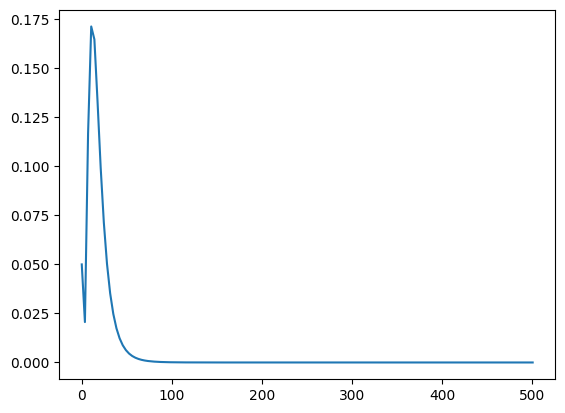

In [8]:
plt.plot(wages, pmf)

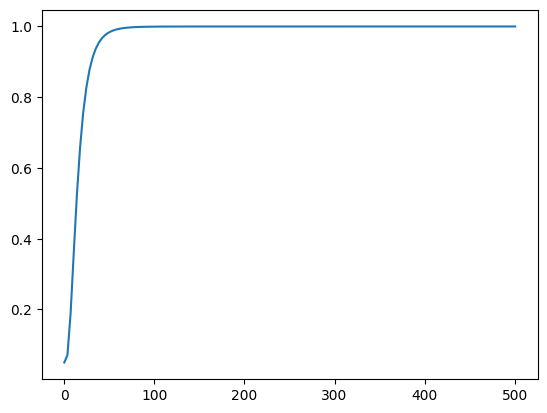

In [9]:
plt.plot(wages, cdf)

We have made the actual wage paid out to the agents the numerare in this model. The term wage and ability is used interchangeably.

### 2. Define agents

The utility function we use is:

$$U(c, l) = u(c) + v(l) = \frac{c^{1 - \gamma} - 1}{1 - \gamma} - \frac{\alpha l^\sigma}{\sigma}$$

s.t.

$$ c \leq w \cdot l - T(w \cdot l) + R$$

With $R$ being the demogrant. Notably, this functional form allows for income effects unlike the quasi-linear case.

In [10]:
class Agent:

    def __init__(self, wage):

        # note that this is a separating equilibrium, so higher ability workers always work more 
        # okay to assume the relative ordering stays the same over time

        self.wage = wage
        self.bracket = int((wage - 0.01) / bin + 1) # 1 indexed
        self.ls = (alpha/((0.65 * self.wage)**(1 - gamma)))**(1/(1 - gamma - sigma)) # the guessed labor supply assuming a flat rate of 0.35
        self.dudc = None # u'(c(theta))
        self.consumption = None
        self.taxpaid = None

    def taxes(self, tax_schedule, earnings, default_rate = 0.35):
        '''
        This function calculates the tax burden for this agent.
        When it comes to the i^{th} agent, the previous agents' earnings would have been calculated (see the description up top).

        Inputs:
        tax_schedule: a list of tuples (cutoff, rate), where the i^{th} entry is (w(z_i), T'(w))
        earnings: labor supply * wage
        default_rate: applies to the first iteration of the lowest bracket when we supply an empty tax schedule

        Outputs:
        (float) tax burden
        '''

        total_tax = 0 # cumulative tax burden
        prev_cutoff = 0

        for i in range(self.bracket - 1): # due to the fact that the brackets are 1-indexed

            cutoff, rate = tax_schedule[i]
            
            if earnings < cutoff:
                break

            total_tax += rate * (cutoff - prev_cutoff)
            prev_cutoff = cutoff

        if len(tax_schedule) == 0:
            total_tax += (earnings - max(prev_cutoff, 0)) * default_rate
        else:
            total_tax += (earnings - max(prev_cutoff, 0)) * tax_schedule[self.bracket - 2][1]

        return total_tax
    
    def max_util(self, transfer, tax_schedule):
        '''
        utility maximization assuming walrus's law holds (no extra budget)

        Inputs:
        transfer: from the government.
        tax schedule: see definition aboe

        Outputs:
        pre-tax earnings
        '''
        
        # negative of the utility function since the routine minimizes instead of optimizes
        
        neg_utility_func = lambda l: -1 * ((self.wage*l - self.taxes(tax_schedule, self.wage*l) + transfer)**(1 - gamma) - 1)/(1 - gamma) + alpha*(l**(sigma)) / sigma if l >= 0 else 1e9
        result = minimize(neg_utility_func, self.ls)

        self.ls = result.x[0] # new optimal labor supply
        self.taxpaid = self.taxes(tax_schedule, self.wage*self.ls)
        self.consumption = self.wage*self.ls - self.taxpaid + transfer
        self.dudc = (self.wage*self.ls - self.taxes(tax_schedule, self.wage*self.ls) + transfer)**(-1 * gamma) # should do numerical differentiation for general utility functions

        return self.ls*self.wage # pre-tax earnings this turn

Intialization for the search is important for the speed of convergence. We use the previous optimal labor supply as an educated guess for the starting point of the search under the new schedule.

### 3. Iterating to find the fixed point

#### 3.1 - Intialize a starting tax schedule $(T'(w) \equiv 0.35)$

In [11]:
# initially - initialize the economy - flat tax schedule
agents = []
tax_schedule = []
for wage in wages:
    agent = Agent(wage)
    optimal_wage = agent.max_util(transfer, tax_schedule)
    tax_schedule.append((optimal_wage, 0.35))
    agents.append(agent)

#### Update rule:

Planner's FOC (a discretized version of Saez's FOC from his seminal 2001 paper), discretized (see pg. 5 of MWY's appendix):

$$\frac{T'(z)}{(1 - T'(z))} = \frac{1 + \epsilon^u(w)}{\epsilon^c(w)}\frac{u'(c(w))}{w\pi(w)/\Delta}\bigg[\sum_{w_i = w + 1}^{w_N} \frac{\pi(w_i)}{u'(c(w_i))} - (1 - \Pi(w_i)) \sum_{w_i = w_1}^{w_N} \frac{\pi(w_i)}{u'(c(w_i))}\bigg]$$

In [12]:
iterations = 0

while True:

    print(iterations, end = " ")

    revenue_check = True # if the new tansfer is within 1e-6 of the prev
    derivative_check = True # if marginal taxes are not updated by more than 1e-6

    # components of RHS
    cum_sum = [pmf[0]/agents[0].dudc]
    for (idx, agent) in enumerate(agents[1:]):
        cum_sum.append(cum_sum[-1] + pmf[idx]/agent.dudc)

    revenue = 0

    for (index, agent) in enumerate(agents):

        # calculate the new tax rate:
        e_c = 1/(sigma - 1 + alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1))) # compensated elasticity
        e_u = (1 - alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1)))/(sigma - 1 + alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1))) # uncompensated elasticity
        middle_term = agent.dudc/(wages[index] * pmf[index] / bin)
        right_term = (cum_sum[-1] - cum_sum[index]) - (1 - cdf[index]) * cum_sum[-1]
        rhs = (1 + e_u)/e_c * middle_term * right_term
        new_rate = (rhs / (1 + rhs) + tax_schedule[index][1])/2 # avg of the old and new rate - controlling the step size
        revenue += agent.taxpaid * pmf[index]

        # find the new schedule
        if abs(new_rate - tax_schedule[index][1]) > tol:
            derivative_check = False
        
        tax_schedule[index] = (tax_schedule[index][0], new_rate)

    if abs(transfer - revenue) > tol:
        revenue_check = False

    transfer = revenue
     
    if revenue_check and derivative_check:
        break

    for (index, agent) in enumerate(agents):
        pre_tax_earning = agent.max_util(transfer, tax_schedule) # now again with the new transfer
        tax_schedule[index] = (pre_tax_earning, tax_schedule[index][1])

    iterations += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 

### 4. Visuals:

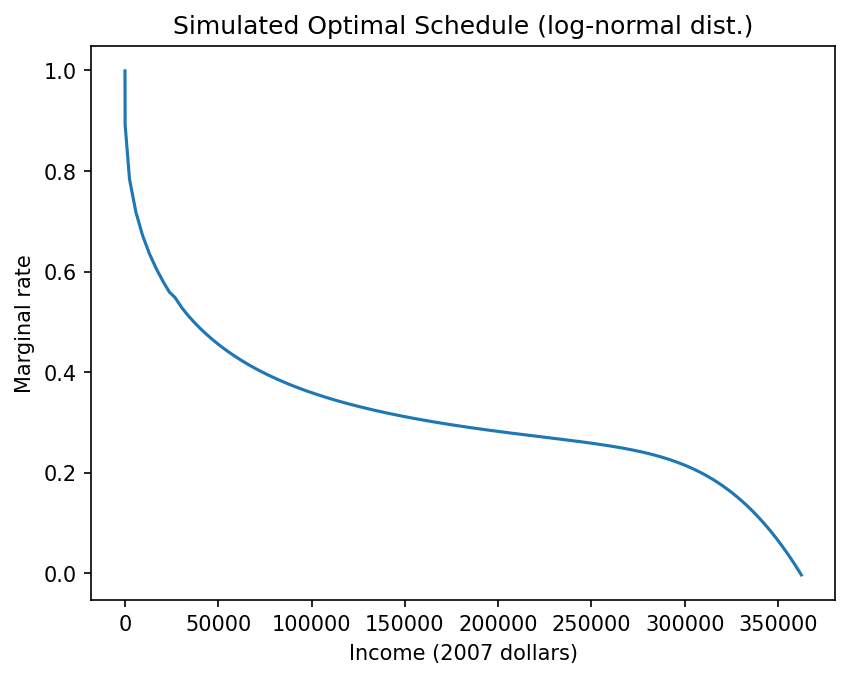

In [17]:
changes = []
rate = []

for point in tax_schedule:
    changes.append(point[0] * scaling)
    rate.append(point[1])

plt.figure(dpi = 150)
plt.plot(changes, rate)
plt.title("Simulated Optimal Schedule (log-normal dist.)")
plt.xlabel("Income (2007 dollars)")
plt.ylabel("Marginal rate")
plt.show()

Text(0, 0.5, 'Hours / Wk (50 work weeks)')

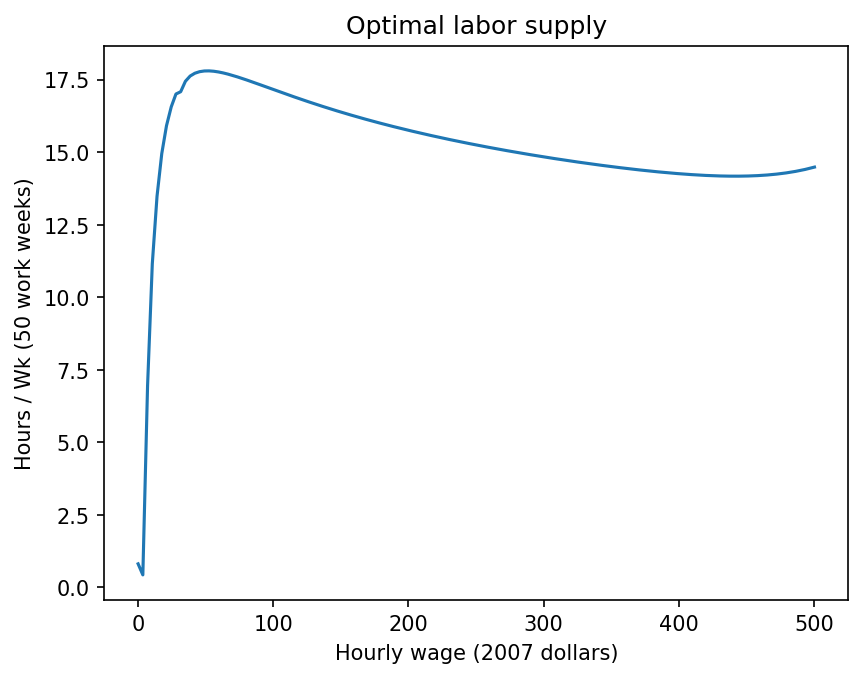

In [23]:
opt_ls = []

for agent in agents:
    opt_ls.append(agent.ls * scaling / 50)

plt.figure(dpi = 150)
plt.plot(wages, opt_ls)
plt.title("Optimal labor supply")
plt.xlabel("Hourly wage (2007 dollars)")
plt.ylabel("Hours / Wk (50 work weeks)")